In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import BlurDataset
from scripts.utils import preprocessing

In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScale = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

Created filtered annotation file at annfile_filtered.txt
Evaluating Model on GPU
Determining wrongly classified samples.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 104/104, 21.8 task/s, elapsed: 5s, ETA:     0s
Number of correctly classified samples: 92
Number of incorrectly classified samples: 12
Removing filtered annotation file annfile_filtered.txt
Creating annotation file at annfile_correct.txt
Creating annotation file at annfile_incorrect.txt
Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:120: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz
Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz
Method for CAM generation: gradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Using annotation labels provided by the annfile.
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 12/12, 4.9 task/s, elapsed: 2s, ETA:     0s
Accumulating Statistics for given imgNames.
Accumulating Statistics for given imgNames.
Accumulating Statistics for given imgNames.
Accumul

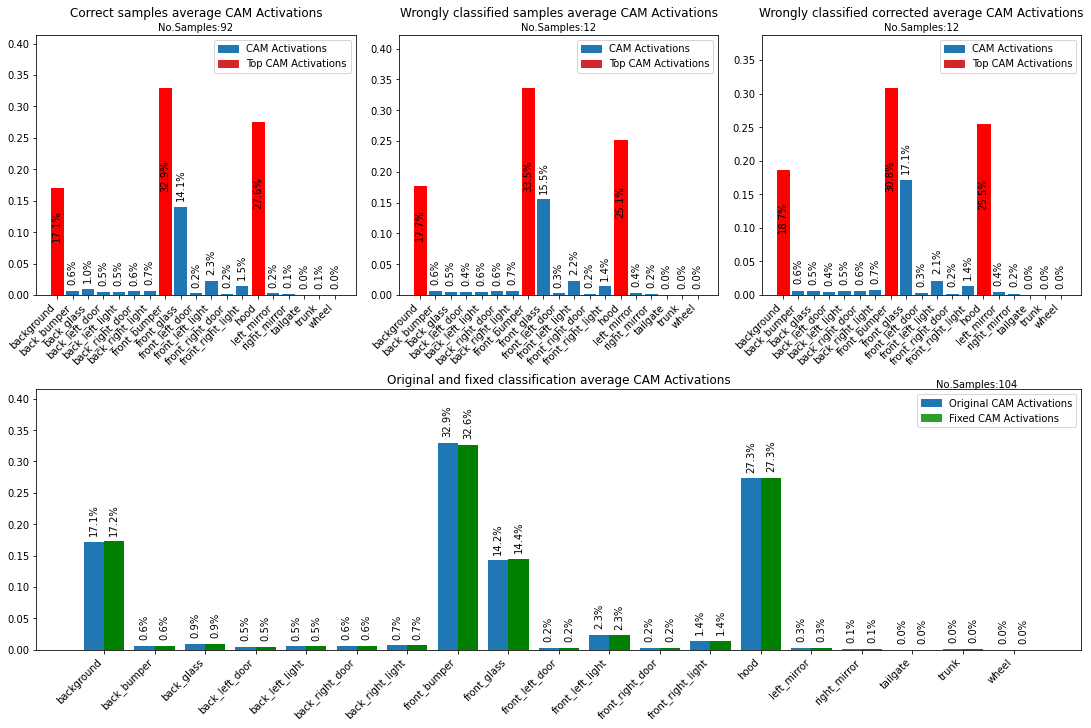

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\Full_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSegs_20_08_2022.jpg
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to wronlyClassifiedResults.xlsx.


In [36]:
generate_statistics.generate_statistics_missclassified(imgRoot=imgRootVal, camConfig=configCAMResOG, 
                                                       camCheckpoint=checkpointCAMResOG, camData=camDataGradCAM,
                                                       segData=segDataPath, method='gradcam', segConfig=configSeg,
                                                       segCheckpoint=checkpointSeg, annfile=annfileValGt)

In [3]:
classes = preprocessing.load_classes(segConfig=configSeg, segCheckpoint=checkpointSeg)

In [4]:
b = BlurDataset(imgRoot=imgRootVal, classes=classes, segData=segDataPathNoScale,
                blurredSegment='front_left_light', dataClasses=['Acura_Acura_ILX'])
c = BlurDataset(imgRoot=imgRootVal, classes=classes, segData=segDataPathNoScale,
                blurredSegment='front_bumper', dataClasses=['Acura_Acura_ILX'])
d = BlurDataset(imgRoot=imgRootVal, classes=classes, segData=segDataPathNoScale,
                blurredSegment=['front_left_light', 'front_right_light'], dataClasses=['Acura_Acura_ILX'])

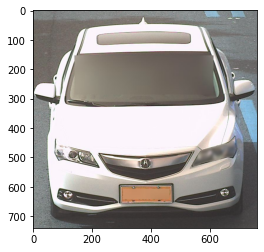

In [5]:
plt.imshow(b[0]['img'])

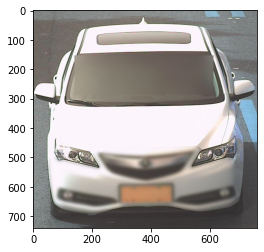

In [6]:
plt.imshow(c[0]['img'])

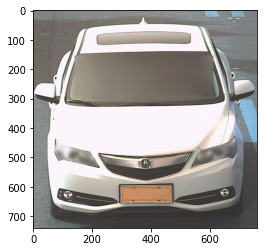

In [7]:
plt.imshow(d[0]['img'])

In [9]:
classes

('background',
 'back_bumper',
 'back_glass',
 'back_left_door',
 'back_left_light',
 'back_right_door',
 'back_right_light',
 'front_bumper',
 'front_glass',
 'front_left_door',
 'front_left_light',
 'front_right_door',
 'front_right_light',
 'hood',
 'left_mirror',
 'right_mirror',
 'tailgate',
 'trunk',
 'wheel')